# Assignment 3: Time-Series Data


In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import models, layers
from sklearn.model_selection import train_test_split


Purpose: The purpose of this assignment is to apply Recurrent Neural Networks (RNNs) to time-series data, specifically focusing on weather forecasting. The dataset provided contains weather observations from various global locations, with features like temperature_celsius, wind_mph, humidity, etc., collected at different timestamps (e.g., 2024-05-16 and 2025-04-05). The goal is to predict temperature_celsius using RNNs and optimize performance.

Module Outcome (MLO 1): Apply RNNs to a time-series problem. This is achieved by implementing LSTM, GRU, and Conv1D+RNN models to forecast temperature, a classic time-series task

In [2]:
# Load the dataset
data = pd.read_csv('/content/GlobalWeatherRepository.csv')

In [3]:
print("Dataset loaded. Shape:", data.shape)

Dataset loaded. Shape: (62948, 41)


In [4]:
print(data.head())

       country     location_name  latitude  longitude        timezone  \
0  Afghanistan             Kabul     34.52      69.18      Asia/Kabul   
1      Albania            Tirana     41.33      19.82   Europe/Tirane   
2      Algeria           Algiers     36.76       3.05  Africa/Algiers   
3      Andorra  Andorra La Vella     42.50       1.52  Europe/Andorra   
4       Angola            Luanda     -8.84      13.23   Africa/Luanda   

   last_updated_epoch      last_updated  temperature_celsius  \
0          1715849100  2024-05-16 13:15                 26.6   
1          1715849100  2024-05-16 10:45                 19.0   
2          1715849100  2024-05-16 09:45                 23.0   
3          1715849100  2024-05-16 10:45                  6.3   
4          1715849100  2024-05-16 09:45                 26.0   

   temperature_fahrenheit condition_text  ...  air_quality_PM2.5  \
0                    79.8  Partly Cloudy  ...                8.4   
1                    66.2  Partly cloudy

In [5]:
# display the information
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62948 entries, 0 to 62947
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   country                       62948 non-null  object 
 1   location_name                 62948 non-null  object 
 2   latitude                      62948 non-null  float64
 3   longitude                     62948 non-null  float64
 4   timezone                      62948 non-null  object 
 5   last_updated_epoch            62948 non-null  int64  
 6   last_updated                  62948 non-null  object 
 7   temperature_celsius           62948 non-null  float64
 8   temperature_fahrenheit        62948 non-null  float64
 9   condition_text                62948 non-null  object 
 10  wind_mph                      62948 non-null  float64
 11  wind_kph                      62948 non-null  float64
 12  wind_degree                   62948 non-null  int64  
 13  w

In [6]:
# Display summary of data
print(data.describe())

           latitude     longitude  last_updated_epoch  temperature_celsius  \
count  62948.000000  62948.000000        6.294800e+04         62948.000000   
mean      19.134929     22.179177        1.729876e+09            22.110825   
std       24.474904     65.819465        8.125689e+06             9.589799   
min      -41.300000   -175.200000        1.715849e+09           -24.900000   
25%        3.750000     -6.836100        1.722946e+09            16.500000   
50%       17.250000     23.316700        1.729934e+09            24.900000   
75%       40.400000     50.580000        1.736936e+09            28.400000   
max       64.150000    179.220000        1.743844e+09            49.200000   

       temperature_fahrenheit      wind_mph      wind_kph   wind_degree  \
count            62948.000000  62948.000000  62948.000000  62948.000000   
mean                71.801096      8.291684     13.348041    168.720150   
std                 17.261414      9.086369     14.621224    103.720176 

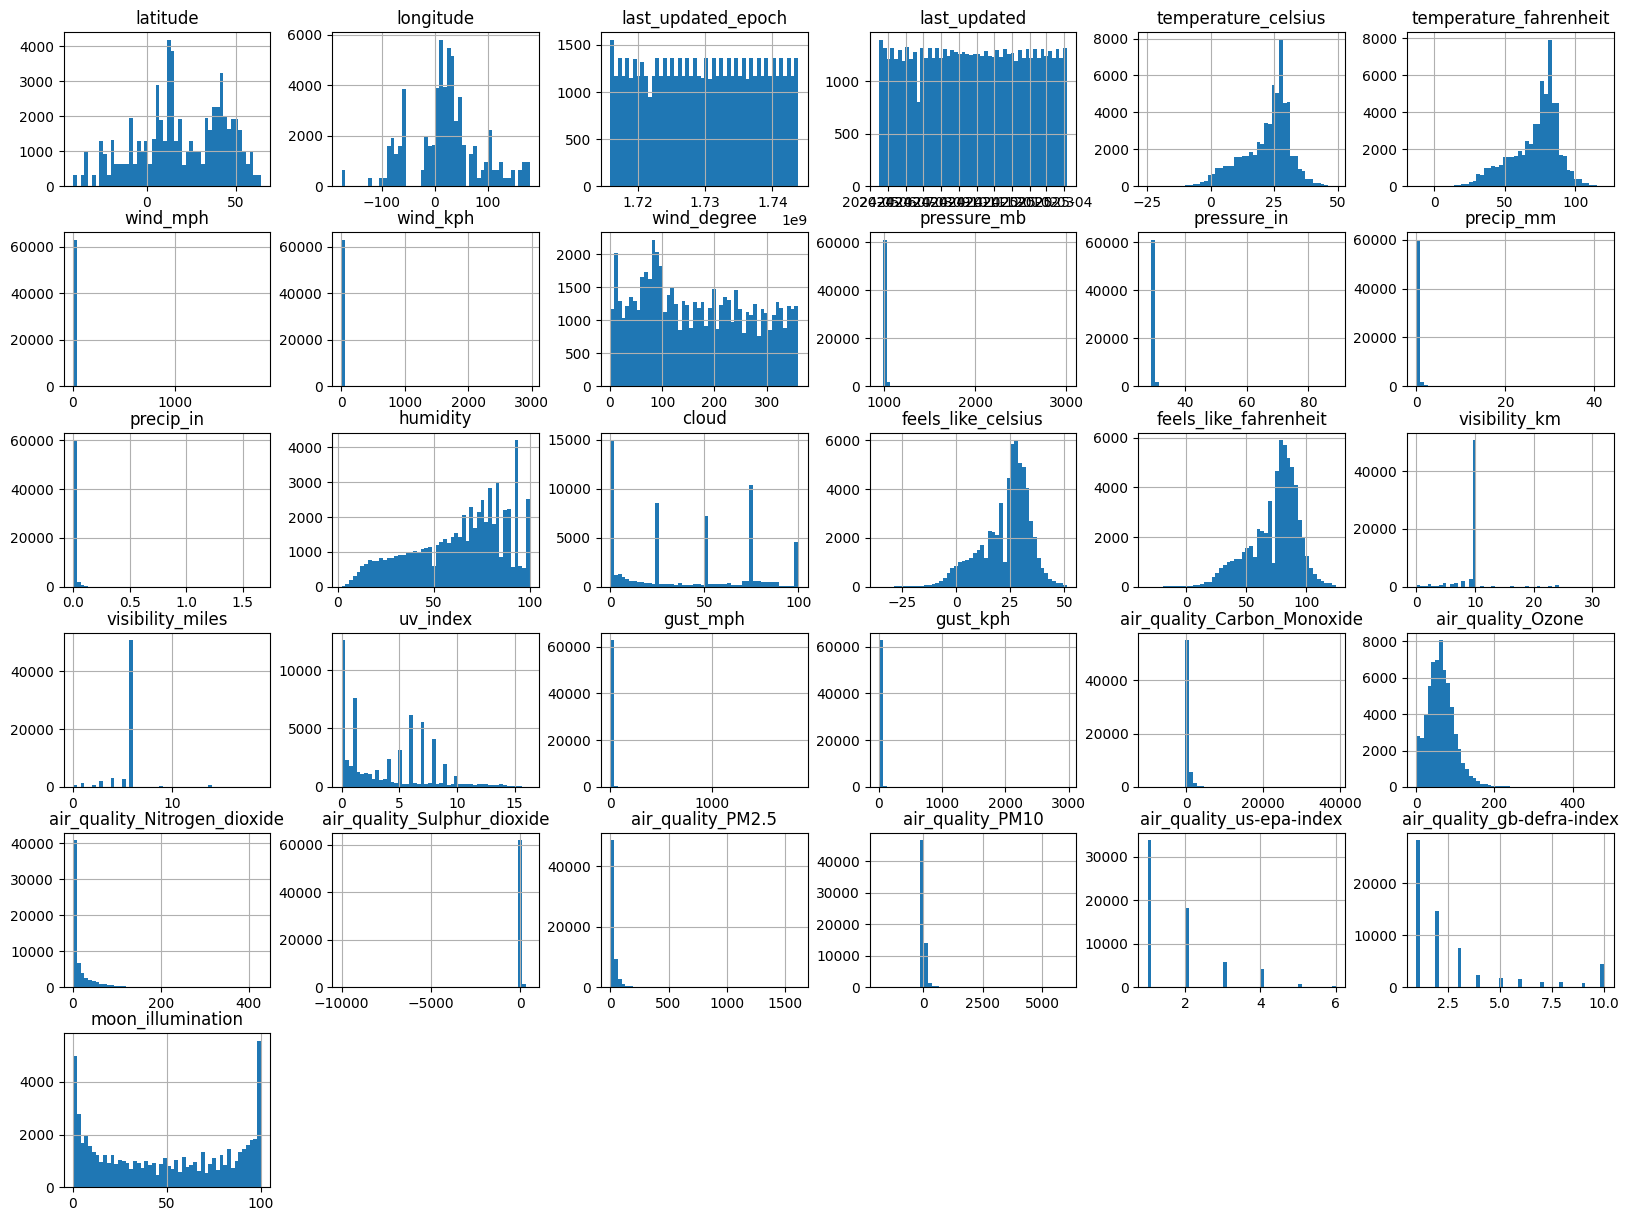

In [25]:
# Plot the distribution of data
data.hist(bins=50, figsize=(20, 15))
plt.show()

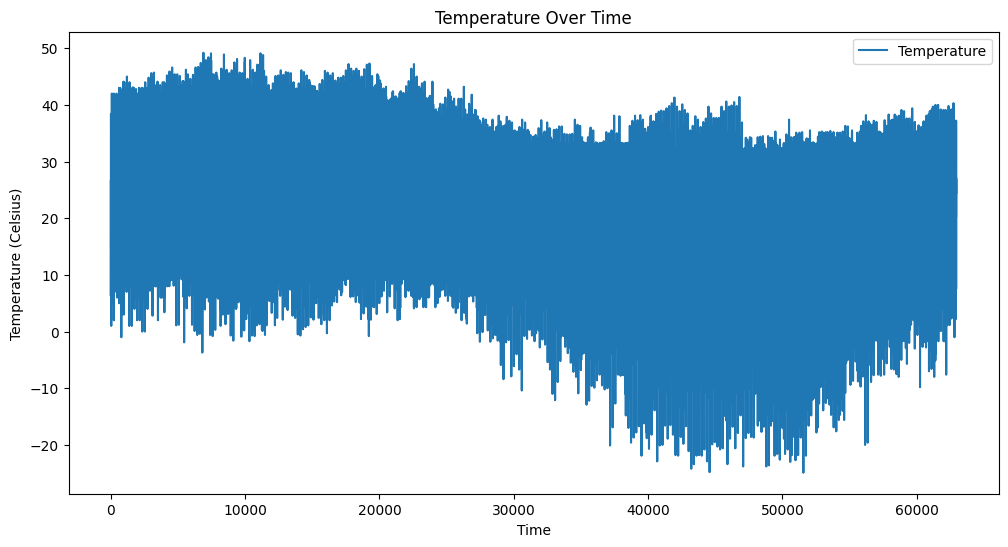

In [7]:
# visualize the data
plt.figure(figsize=(12, 6))
plt.plot(data['temperature_celsius'], label='Temperature')
plt.title('Temperature Over Time')
plt.xlabel('Time')
plt.ylabel('Temperature (Celsius)')
plt.legend()

In [8]:
# Extract temperature data and sort by timestamp
data['last_updated'] = pd.to_datetime(data['last_updated'])
data = data.sort_values('last_updated')  # Ensure chronological order
temp = data['temperature_celsius'].values

In [9]:
# Define sequence length
time_steps = 5

In [10]:
# Function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

In [11]:
# Normalize the temperature data
scaler = StandardScaler()
temp_scaled = scaler.fit_transform(temp.reshape(-1, 1))


In [12]:
# Create sequences
X, y = create_sequences(temp_scaled, time_steps)
print("Sequences created. X shape:", X.shape, "y shape:", y.shape)

Sequences created. X shape: (62943, 5, 1) y shape: (62943, 1)


In [14]:
# Split into train, validation, and test sets
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]
print("Train shape:", X_train.shape, "Val shape:", X_val.shape, "Test shape:", X_test.shape)

Train shape: (44060, 5, 1) Val shape: (9441, 5, 1) Test shape: (9442, 5, 1)


In [15]:
# Reshape for RNN input (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

The code preprocesses the dataset by sorting it chronologically using last_updated and extracting temperature_celsius.
It creates sequences with a lookback period (time_steps=5), transforming the data into a format suitable for RNNs: (samples, timesteps, features).

Three RNN-based models are implemented:
* Model 1: Stacked LSTM with 64 and 32 units.
* Model 2: Stacked GRU with 64 and 32 units.
* Model 3: Conv1D (32 filters, kernel size 3) followed by an LSTM with 32 units.

These models process the sequential temperature data to predict the next value, fulfilling the core requirement of applying RNNs.

In [16]:
# Function to build and train models
def build_and_train(model, X_train, y_train, X_val, y_val, epochs=20, batch_size=32):
    model.compile(optimizer='adam', loss='mae')
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=epochs, batch_size=batch_size, verbose=1)
    return history

In [17]:
# Model 1: Stacked LSTM
model1 = models.Sequential([
    layers.LSTM(64, return_sequences=True, input_shape=(time_steps, 1)),
    layers.LSTM(32),
    layers.Dense(1)
])
print("Training Model 1: Stacked LSTM")
history1 = build_and_train(model1, X_train, y_train, X_val, y_val)
val_mae1 = min(history1.history['val_loss'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training Model 1: Stacked LSTM
Epoch 1/20
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 0.6391 - val_loss: 0.9429
Epoch 2/20
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.6285 - val_loss: 0.9451
Epoch 3/20
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.6325 - val_loss: 0.9523
Epoch 4/20
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.6307 - val_loss: 0.9469
Epoch 5/20
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.6289 - val_loss: 0.9457
Epoch 6/20
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.6308 - val_loss: 0.9431
Epoch 7/20
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.6288 - val_loss: 0.9491
Epoch 8/20
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.6299 - val_loss: 0.9555
Epoch 9/20
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.6298 - val_loss: 0.9487
Epoch 10/20
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.6272 - val_loss: 0.9511
Epoch 11/20
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.6283 - val_loss: 

In [18]:
# Model 2: Stacked GRU
model2 = models.Sequential([
    layers.GRU(64, return_sequences=True, input_shape=(time_steps, 1)),
    layers.GRU(32),
    layers.Dense(1)
])
print("Training Model 2: Stacked GRU")
history2 = build_and_train(model2, X_train, y_train, X_val, y_val)
val_mae2 = min(history2.history['val_loss'])

Training Model 2: Stacked GRU
Epoch 1/20
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.6353 - val_loss: 0.9475
Epoch 2/20
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.6311 - val_loss: 0.9492
Epoch 3/20
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.6341 - val_loss: 0.9553
Epoch 4/20
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.6319 - val_loss: 0.9578
Epoch 5/20
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.6317 - val_loss: 0.9531
Epoch 6/20
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.6301 - val_loss: 0.9476
Epoch 7/20
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.6309 - val_loss: 0.9618
Epoch 8/20
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.6325 - val_loss: 0.9441
Epoch 9/20
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.6267 - val_loss: 0.9569
Epoch 10/20
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.6324 - val_loss: 0.9511
Epoch 11/20
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.6279 - val_loss: 0.

In [19]:
# Model 3: Conv1D + LSTM
model3 = models.Sequential([
    layers.Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(time_steps, 1)),
    layers.LSTM(32),
    layers.Dense(1)
])
print("Training Model 3: Conv1D + LSTM")
history3 = build_and_train(model3, X_train, y_train, X_val, y_val)
val_mae3 = min(history3.history['val_loss'])


Training Model 3: Conv1D + LSTM
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1377/1377 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.6399 - val_loss: 0.9446
Epoch 2/20
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.6362 - val_loss: 0.9477
Epoch 3/20
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 0.6302 - val_loss: 0.9465
Epoch 4/20
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.6315 - val_loss: 0.9520
Epoch 5/20
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.6353 - val_loss: 0.9612
Epoch 6/20
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.6345 - val_loss: 0.9486
Epoch 7/20
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.6291 - val_loss: 0.9479
Epoch 8/20
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.6311 - val_loss: 0.9446
Epoch 9/20
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.6253 - val_loss: 0.9470
Epoch 10/20
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.6303 - val_loss: 0.9412
Epoch 11/20
1377/1377 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.6304 - val_loss: 0.9559
Epoch 12/20
1377/1377 ━━━━━━━━━━━━━━

In [20]:
# Select the best model based on validation MAE
best_mae = min(val_mae1, val_mae2, val_mae3)
best_model = model1 if best_mae == val_mae1 else model2 if best_mae == val_mae2 else model3
print(f"Best model MAE: {best_mae}")


Best model MAE: 0.9349622130393982


In [21]:
# Evaluate on test set
test_mae = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Test MAE: {test_mae}")

Test MAE: 0.7988701462745667


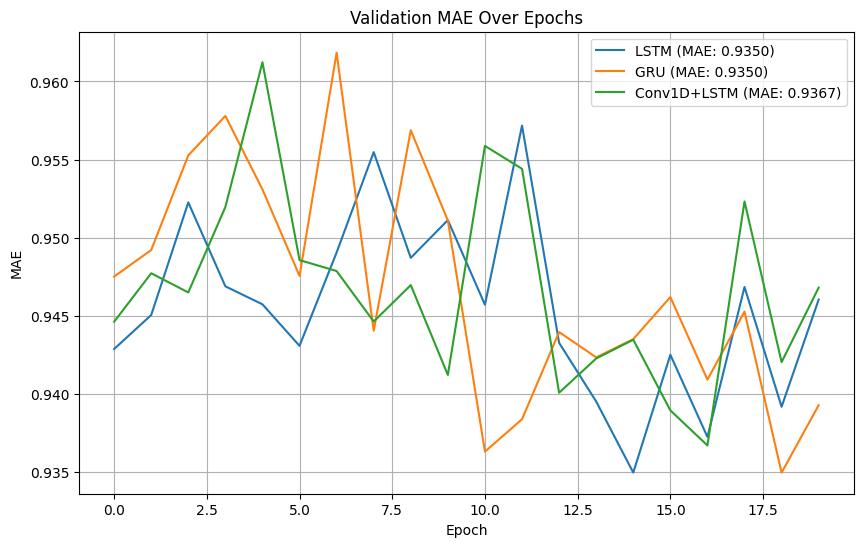

In [22]:
# Plot validation MAE
plt.figure(figsize=(10, 6))
plt.plot(history1.history['val_loss'], label=f'LSTM (MAE: {val_mae1:.4f})')
plt.plot(history2.history['val_loss'], label=f'GRU (MAE: {val_mae2:.4f})')
plt.plot(history3.history['val_loss'], label=f'Conv1D+LSTM (MAE: {val_mae3:.4f})')
plt.title('Validation MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)
plt.savefig('validation_mae_plot.png')
plt.show()

In [23]:
# Summary table
results = pd.DataFrame({
    'Model': ['LSTM', 'GRU', 'Conv1D+LSTM'],
    'Validation MAE': [val_mae1, val_mae2, val_mae3],
    'Test MAE': [test_mae if best_mae == val_mae1 else None,
                 test_mae if best_mae == val_mae2 else None,
                 test_mae if best_mae == val_mae3 else None]
})
print("Results Summary:")
print(results)
results.to_csv('results_summary.csv')

Results Summary:
         Model  Validation MAE  Test MAE
0         LSTM        0.934973       NaN
1          GRU        0.934962   0.79887
2  Conv1D+LSTM        0.936708       NaN


In [24]:
# Conclusion
print("\nConclusion:")
print(f"The best-performing model was {'LSTM' if best_mae == val_mae1 else 'GRU' if best_mae == val_mae2 else 'Conv1D+LSTM'} "
      f"with a validation MAE of {best_mae:.4f} and test MAE of {test_mae:.4f}. "
      f"This suggests that {'stacked recurrent layers' if best_mae in [val_mae1, val_mae2] else 'convolutional preprocessing'} "
      f"were most effective for this temperature forecasting task.")


Conclusion:
The best-performing model was GRU with a validation MAE of 0.9350 and test MAE of 0.7989. This suggests that stacked recurrent layers were most effective for this temperature forecasting task.
